In [14]:
import pandas as pd
from datasets import load_dataset

import string
from nltk.stem.snowball import stopwords

import matplotlib.pyplot as plt
from wordcloud import WordCloud


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

In [19]:
from sklearn.metrics import f1_score

In [15]:
# Load the Yahoo! Answers Topic Classification dataset
dataset = load_dataset("yahoo_answers_topics")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer'],
        num_rows: 1400000
    })
    test: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer'],
        num_rows: 60000
    })
})


In [3]:
train = dataset['train'].to_pandas()
train = train.drop(columns='id')

In [4]:
topic_mapping = {
    0: "Society & Culture",
    1: "Science & Mathematics",
    2: "Health",
    3: "Education & Reference",
    4: "Computers & Internet",
    5: "Sports",
    6: "Business & Finance",
    7: "Entertainment & Music",
    8: "Family & Relationships",
    9: "Politics & Government"
}

train['topic_name'] = train['topic'].map(topic_mapping)

In [5]:
punctuation = set(string.punctuation)
# get rid of special characters
alphabet = 'abcdefghijklmnopqrstuvwxyz0123456789 '
stopwordsSet = set(stopwords.words("english"))

In [6]:
def clean_text(content):
    content = content.lower()
    content = ''.join([c for c in content if c not in punctuation and c in alphabet])
    content = ' '.join(w for w in content.split() if w not in stopwordsSet)
    return content

In [7]:
train.question_title = train.question_title.apply(lambda x: clean_text(x))

train.question_content = train.question_content.apply(lambda x: clean_text(x))
train.best_answer = train.best_answer.apply(lambda x: clean_text(x))

In [8]:
train

,topic,question_title,question_content,best_answer,topic_name
0,4,doesnt optical mouse work glass table,even surfaces,optical mice use led camera rapidly capture im...,Computers & Internet
1,5,best offroad motorcycle trail,longdistance trail throughout ca,hear mojave road amazingbr nsearch online,Sports
2,2,trans fat reduce,heard tras fat bad body find daily food,trans fats occur manufactured foods process pa...,Health
3,6,many planes fedex,heard largest airline world,according wwwfedexcom web sitenair fleetbr n b...,Business & Finance
4,6,san francisco bay area make sense rent buy,prices rent price buying make sense mostly ren...,renting vs buying depends goals br ngenerally ...,Business & Finance
...,...,...,...,...,...
1399995,2,ads tv yoko etc regarding height increase use,,increased height 2 feet afterwards yesnnof cou...,Health
1399996,6,ways sell video games,like want sell video games sell,ebay electronic boutique babbages flea markets,Business & Finance
1399997,2,normal nots breast boobs,,normal long cancerous breasts examined every 6...,Health
1399998,0,speak hindi,write,main hindi bol sakti hoonkahiye,Society & Culture


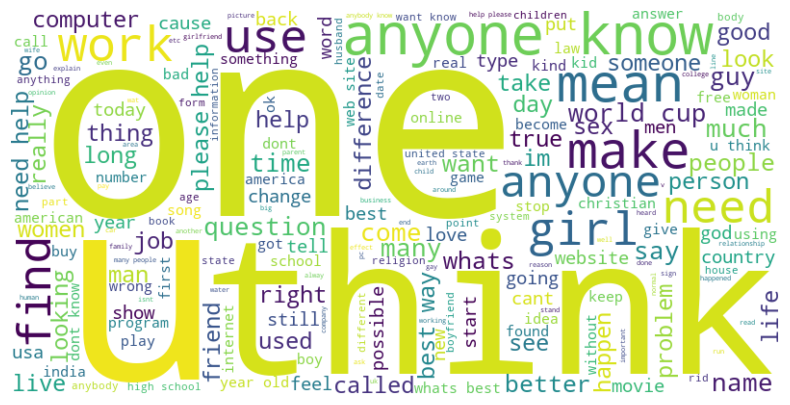

In [9]:
question_titles = " ".join(s for s in train.question_title)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(question_titles)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

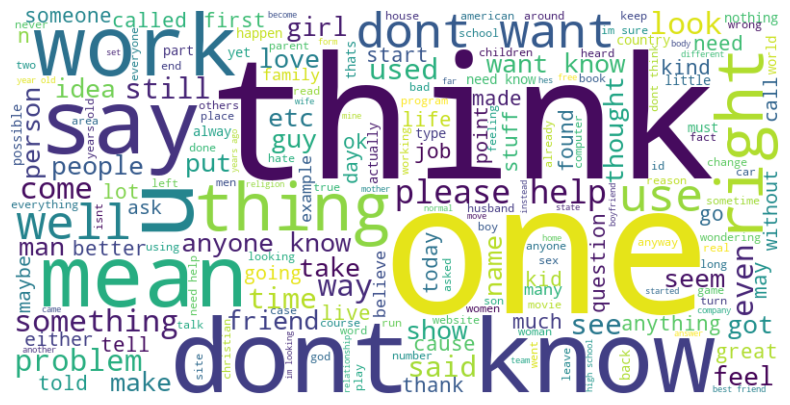

In [10]:
question_contents = " ".join(s for s in train.question_content)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(question_contents)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

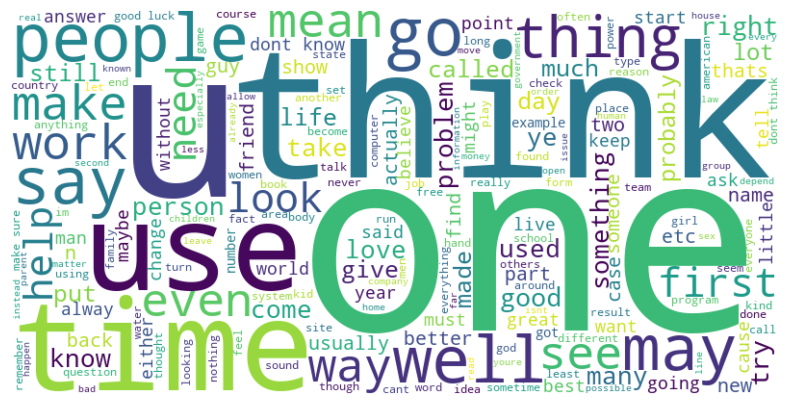

In [11]:
# Sample 20% of the answers
sample_answers = " ".join(s for s in train.best_answer.sample(frac=0.2, random_state=42))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sample_answers)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
# check NaN
train_copy = train.copy()
train_copy.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
nan_counts = train_copy.isna().sum()
nan_counts

topic                    0
question_title        4183
question_content    635515
best_answer          31120
topic_name               0
dtype: int64

In [13]:
# check number of records for each topic
topic_counts = train_copy['topic'].value_counts()
topic_counts

topic
4    140000
5    140000
2    140000
6    140000
1    140000
7    140000
3    140000
8    140000
9    140000
0    140000
Name: count, dtype: int64

In [16]:
# prepare the test set
test = dataset['test'].to_pandas()
test = test.drop(columns='id')

In [32]:
def train_tfidf_model(train, test, X_column):
    # Select the appropriate column(s) for features
    if X_column == 'question_title_content':
        data_features_train = train['question_title'] + ' ' + train['question_content']
        data_features_test = test['question_title'] + ' ' + test['question_content']
    elif X_column == 'best_answer':
        data_features_train = train['best_answer']
        data_features_test = test['best_answer']
    elif X_column == 'all':
        data_features_train = train['question_title'] + ' ' + train['question_content'] + ' ' + train['best_answer']
        data_features_test = test['question_title'] + ' ' + test['question_content'] + ' ' + test['best_answer']
    else:
        raise ValueError("Invalid X_column value. Choose from 'question_title_content', 'best_answer', 'all'.")
    
    y_train = train['topic']
    y_test = test['topic']
    
    # Create a pipeline with TF-IDF vectorizer and Naive Bayes classifier
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
        ('clf', MultinomialNB())
    ])
    
    # Fit the model
    pipeline.fit(data_features_train, y_train)
    
    # Predict on test data
    y_pred = pipeline.predict(data_features_test)
    
    # Calculate and print F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Model F1 Score: {f1}")

In [28]:
train_tfidf_model(train, test, 'question_title_content')

Model F1 Score: 0.6527370487514572


In [33]:
train_tfidf_model(train, test, 'best_answer')

Model F1 Score: 0.5433457950918524


In [34]:
train_tfidf_model(train, test, 'all')

Model F1 Score: 0.6730847617106435
